# Understanding the Semantic Kernel Process Framework

This notebook provides a comprehensive introduction to the Process Framework within Microsoft's Semantic Kernel. The Process Framework is a powerful tool that allows developers to build structured, event-driven AI workflows that can handle complex business logic while leveraging AI capabilities.

## What This Notebook Covers

This tutorial guides you through:
- **Core concepts of the Process Framework:**  
  Understanding the fundamental building blocks like processes, steps, events, and state management.
- **Building a "Hello World" process:**  
  Creating your first simple workflow to grasp the basics.
- **Creating a conversational chatbot:**  
  Implementing a more practical application with user input and AI responses.
- **Developing a content creation workflow:**  
  Building an advanced multi-step process with state management and conditional logic.
- **Best practices and advanced patterns:**  
  Learning how to effectively design and implement robust processes.

## Why Use the Process Framework?

The Process Framework solves several key challenges when building AI applications:
- **Structured workflows:**  
  Create predictable patterns for AI interaction.
- **State management:**  
  Maintain context across multiple steps.
- **Conditional logic:**  
  Implement decision points based on AI or user input.
- **Error handling:**  
  Gracefully manage exceptions in AI-driven processes.
- **Reusability:**  
  Build modular components that can be composed into larger workflows.

By the end of this notebook, you'll understand how to design and implement sophisticated AI-powered workflows using Semantic Kernel's Process Framework, enabling you to create more robust and maintainable applications that leverage large language models in a structured way.

In [ ]:
# Install required packages
!pip install semantic-kernel python-dotenv mermaid-py --quiet

In [2]:
import os
import asyncio
from enum import Enum
import mermaid as md
from dotenv import load_dotenv

# Import Semantic Kernel components
import semantic_kernel as sk
from semantic_kernel import Kernel
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion
from semantic_kernel.contents import ChatHistory
from semantic_kernel.functions import kernel_function
from semantic_kernel.kernel_pydantic import KernelBaseModel
from semantic_kernel.processes.kernel_process.kernel_process_step import (
    KernelProcessStep,
)
from semantic_kernel.processes.kernel_process.kernel_process_step_context import (
    KernelProcessStepContext,
)
from semantic_kernel.processes.kernel_process.kernel_process_step_state import (
    KernelProcessStepState,
)
from semantic_kernel.processes.local_runtime.local_event import KernelProcessEvent
from semantic_kernel.processes.local_runtime.local_kernel_process import start
from semantic_kernel.processes.process_builder import ProcessBuilder

# Load environment variables
load_dotenv()

print("Environment set up successfully!")

/Users/ali/Dev/ip/semantic-kernel-workshop/.venv/lib/python3.13/site-packages/google_crc32c/__init__.py:29: RuntimeWarning: As the c extension couldn't be imported, `google-crc32c` is using a pure python implementation that is significantly slower. If possible, please configure a c build environment and compile the extension
  warnings.warn(_SLOW_CRC32C_WARNING, RuntimeWarning)


Environment set up successfully!


## 1. Understanding the Process Framework

The Process Framework in Semantic Kernel provides a structured way to build AI-powered workflows. It consists of several key components:

1. **Process**: The main container that defines a workflow
2. **Steps**: Individual units of work within a process
3. **Events**: Triggers that move the process from one step to another
4. **State**: Shared data and context between steps
5. **Runtime**: The engine that executes the process

Let's start building a hello world workflow to understand the concepts a bit better!

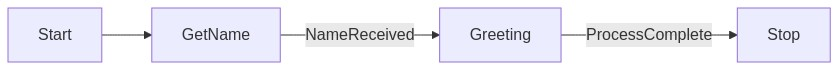

In [3]:
%%mermaidjs --img
flowchart LR
    A[Start] --> B[GetName]
    B -- "NameReceived" --> C[Greeting]
    C -- "ProcessComplete" --> D[Stop]

In [11]:
# Define the events our process will use
class HelloWorldEvents(Enum):
    StartProcess = "startProcess"
    NameReceived = "nameReceived"
    ProcessComplete = "processComplete"


# Define the state for our process
class HelloWorldState(KernelBaseModel):
    name: str = ""
    greeting: str = ""


# Step 1: Get the user's name
class GetNameStep(KernelProcessStep[HelloWorldState]):
    def create_default_state(self) -> HelloWorldState:
        """Creates the default HelloWorldState."""
        return HelloWorldState()

    async def activate(self, state: KernelProcessStepState[HelloWorldState]):
        """Initialize the step's state when activated."""
        self.state = state.state or self.create_default_state()
        print("GetNameStep activated")

    @kernel_function(name="get_name")
    async def get_name(self, context: KernelProcessStepContext):
        """Get the user's name."""
        print("What is your name?")
        name = input("Name: ")

        # Store the name in our state
        self.state.name = name
        print(f"Name set to: {self.state.name}")

        # Emit an event to signal that we have the name
        await context.emit_event(
            process_event=HelloWorldEvents.NameReceived, data=self.state
        )


# Step 2: Display the greeting
class DisplayGreetingStep(KernelProcessStep[HelloWorldState]):
    async def activate(self, state: KernelProcessStepState[HelloWorldState]):
        """Initialize the step's state when activated."""
        self.state = state.state or HelloWorldState()
        print("DisplayGreetingStep activated")

    @kernel_function(name="display_greeting")
    async def display_greeting(
        self, context: KernelProcessStepContext, hello_state: HelloWorldState = None
    ):
        """Display the greeting and complete the process."""
        # If we received state from the event, use it
        if hello_state:
            self.state = hello_state

        # Generate the greeting
        self.state.greeting = f"Hello, {self.state.name}! Welcome to the Semantic Kernel Process Framework."

        # Display the greeting with some decoration
        print("\n" + "=" * 50)
        print(self.state.greeting)
        print("=" * 50 + "\n")

        # Emit an event to signal that the process is complete
        await context.emit_event(
            process_event=HelloWorldEvents.ProcessComplete, data=None
        )


# Function to run the process
async def run_hello_world_process():
    # Create a kernel
    kernel = Kernel()

    # Create a process builder
    process = ProcessBuilder(name="HelloWorld")

    # Add the steps to the process
    name_step = process.add_step(GetNameStep)
    greeting_step = process.add_step(DisplayGreetingStep)

    # Define the process flow using events
    # 1. The StartProcess event triggers the GetNameStep
    process.on_input_event(event_id=HelloWorldEvents.StartProcess).send_event_to(
        target=name_step
    )

    # 2. When name is received, send to greeting generation step
    name_step.on_event(event_id=HelloWorldEvents.NameReceived).send_event_to(
        target=greeting_step, parameter_name="hello_state"
    )

    # 3. When process is complete, stop the process
    greeting_step.on_event(event_id=HelloWorldEvents.ProcessComplete).stop_process()

    # Build the process
    kernel_process = process.build()

    # Start the process with the initial event
    await start(
        process=kernel_process,
        kernel=kernel,
        initial_event=KernelProcessEvent(id=HelloWorldEvents.StartProcess, data=None),
    )

In [ ]:
await run_hello_world_process()

Lets explain each of the components that make up the hello world process
---

### 1. Events
Events are the communication mechanism between steps in a process. They allow a step to signal that it has completed work and provide data to other steps.

```python
class HelloWorldEvents(Enum):
    StartProcess = "startProcess"
    NameReceived = "nameReceived"
    # ...
```

---
### 2. State
State represents the data that flows through the process. Each step can read or modify the state.

```python
class HelloWorldState(KernelBaseModel):
    name: str = ""
    greeting: str = ""
```
---
### 3. Steps
Steps are the building blocks of a process. Each step performs a specific task and can emit events to trigger other steps.

```python
class GetNameStep(KernelProcessStep[HelloWorldState]):
    # The activate method is called when the step starts
    async def activate(self, state: KernelProcessStepState[HelloWorldState]):
        # ...
    
    # A kernel function can be called to perform the step's task
    @kernel_function
    async def get_name(self, context: KernelProcessStepContext):
        # ...
```
---
### 4. Process Builder

The Process Builder connects steps together based on events, creating a workflow.

```python
# Create a process builder
process = ProcessBuilder(name="HelloWorld")

# Add steps to the process
name_step = process.add_step(GetNameStep)
# ...

# Connect steps with events
process.on_input_event(event_id=HelloWorldEvents.StartProcess).send_event_to(target=name_step)
name_step.on_event(event_id=HelloWorldEvents.NameReceived).send_event_to(
    target=greeting_step, 
    parameter_name="hello_state"
)
# ...
```
---
### 5. Runtime

The runtime executes the process, handling events and state transitions between steps.

```python
# Build and start the process
kernel_process = process.build()
await start(
    process=kernel_process,
    kernel=kernel,
    initial_event=KernelProcessEvent(id=HelloWorldEvents.StartProcess, data=None),
)
```

In [ ]:
def create_kernel_with_service(service_id="default"):
    """Create a kernel with Azure OpenAI or OpenAI service."""
    kernel = Kernel()

    if (
        os.getenv("AZURE_OPENAI_API_KEY")
        and os.getenv("AZURE_OPENAI_ENDPOINT")
        and os.getenv("AZURE_OPENAI_DEPLOYMENT")
    ):
        print("Using Azure OpenAI service")
        kernel.add_service(
            AzureChatCompletion(
                service_id=service_id,
                deployment_name=os.getenv("AZURE_OPENAI_DEPLOYMENT"),
                endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
                api_key=os.getenv("AZURE_OPENAI_API_KEY"),
                api_version=os.getenv("AZURE_OPENAI_API_VERSION", "2024-12-01-preview"),
            )
        )
    else:
        raise ValueError(
            "No AI service credentials found. Please set up your .env file."
        )

    return kernel


# Create our kernel
kernel = create_kernel_with_service(service_id="process-framework")
print("Kernel created successfully!")

## 2. Creating a Simple Chatbot Process

Now let's create a simple chatbot process that demonstrates the basic concepts:

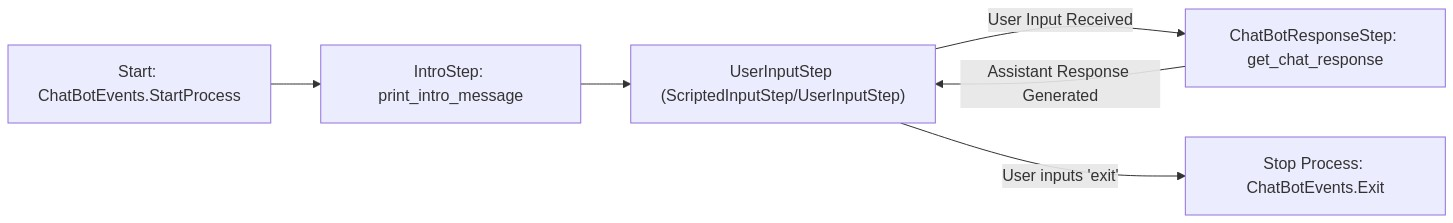

In [4]:
%%mermaidjs --img
flowchart LR
    A[Start: ChatBotEvents.StartProcess] --> B[IntroStep: print_intro_message]
    B --> C["UserInputStep (ScriptedInputStep/UserInputStep)"]
    C -- "User Input Received" --> D[ChatBotResponseStep: get_chat_response]
    D -- "Assistant Response Generated" --> C
    C -- "User inputs 'exit'" --> E[Stop Process: ChatBotEvents.Exit]

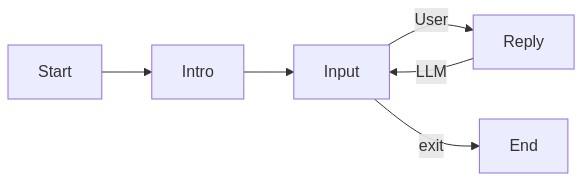

In [5]:
%%mermaidjs --img
flowchart LR
    A[Start] --> B[Intro]
    B --> C[Input]
    C -- "User" --> D[Reply]
    D -- "LLM" --> C
    C -- "exit" --> E[End]

In [16]:
# Create a step to handle the introduction
class IntroStep(KernelProcessStep):
    @kernel_function
    async def print_intro_message(self):
        print("Welcome to the Semantic Kernel Process Framework Chatbot!\n")
        print("Type 'exit' to end the conversation.\n")


# Define events for our chatbot process
class ChatBotEvents(Enum):
    StartProcess = "startProcess"
    IntroComplete = "introComplete"
    UserInputReceived = "userInputReceived"
    AssistantResponseGenerated = "assistantResponseGenerated"
    Exit = "exit"


# Define state for user input step
class UserInputState(KernelBaseModel):
    user_inputs: list[str] = []
    current_input_index: int = 0


# Create a step to handle user input
class UserInputStep(KernelProcessStep[UserInputState]):
    def create_default_state(self) -> "UserInputState":
        """Creates the default UserInputState."""
        return UserInputState()

    async def activate(self, state: KernelProcessStepState[UserInputState]):
        """Activates the step and sets the state."""
        state.state = state.state or self.create_default_state()
        self.state = state.state

    @kernel_function(name="get_user_input")
    async def get_user_input(self, context: KernelProcessStepContext):
        """Gets the user input."""
        if not self.state:
            raise ValueError("State has not been initialized")

        user_message = input("USER: ")

        print(user_message)

        if "exit" in user_message:
            await context.emit_event(process_event=ChatBotEvents.Exit, data=None)
            return

        self.state.current_input_index += 1

        # Emit the user input event
        await context.emit_event(
            process_event=ChatBotEvents.UserInputReceived, data=user_message
        )


# Define state for the chatbot response step
class ChatBotState(KernelBaseModel):
    chat_messages: list = []


# Create a step to handle the chatbot response
class ChatBotResponseStep(KernelProcessStep[ChatBotState]):
    state: ChatBotState = None

    async def activate(self, state: KernelProcessStepState[ChatBotState]):
        """Activates the step and initializes the state object."""
        self.state = state.state or ChatBotState()
        self.state.chat_messages = self.state.chat_messages or []

    @kernel_function(name="get_chat_response")
    async def get_chat_response(
        self, context: KernelProcessStepContext, user_message: str, kernel: Kernel
    ):
        """Generates a response from the chat completion service."""
        # Add user message to the state
        self.state.chat_messages.append({"role": "user", "message": user_message})

        # Get chat completion service and generate a response
        chat_service = kernel.get_service(service_id="process-framework")
        settings = chat_service.instantiate_prompt_execution_settings(
            service_id="process-framework"
        )

        chat_history = ChatHistory()
        chat_history.add_user_message(user_message)
        response = await chat_service.get_chat_message_contents(
            chat_history=chat_history, settings=settings
        )

        if response is None:
            raise ValueError(
                "Failed to get a response from the chat completion service."
            )

        answer = response[0].content

        print(f"ASSISTANT: {answer}")

        # Update state with the response
        self.state.chat_messages.append(answer)

        # Emit an event: assistantResponse
        await context.emit_event(
            process_event=ChatBotEvents.AssistantResponseGenerated, data=answer
        )

In [17]:
# Function to run the chatbot process
async def run_chatbot_process():
    # Create a process builder
    process = ProcessBuilder(name="ChatBot")

    # Define the steps
    intro_step = process.add_step(IntroStep)
    user_input_step = process.add_step(UserInputStep)
    response_step = process.add_step(ChatBotResponseStep)

    # Define the input event that starts the process and where to send it
    process.on_input_event(event_id=ChatBotEvents.StartProcess).send_event_to(
        target=intro_step
    )

    # Define the event that triggers the next step in the process
    intro_step.on_function_result(
        function_name=IntroStep.print_intro_message.__name__
    ).send_event_to(target=user_input_step)

    # Define the event that triggers the process to stop
    user_input_step.on_event(event_id=ChatBotEvents.Exit).stop_process()

    # For the user step, send the user input to the response step
    user_input_step.on_event(event_id=ChatBotEvents.UserInputReceived).send_event_to(
        target=response_step, parameter_name="user_message"
    )

    # For the response step, send the response back to the user input step
    response_step.on_event(
        event_id=ChatBotEvents.AssistantResponseGenerated
    ).send_event_to(target=user_input_step)

    # Build the kernel process
    kernel_process = process.build()

    # Start the process
    await start(
        process=kernel_process,
        kernel=kernel,
        initial_event=KernelProcessEvent(id=ChatBotEvents.StartProcess, data=None),
    )

In [ ]:
# Run the chatbot process
# Uncomment the following line to run the chatbot process
await run_chatbot_process()

## 3. Creating a Multi-Step Process with State

Let's create a more complex process that demonstrates state management and conditional branching:

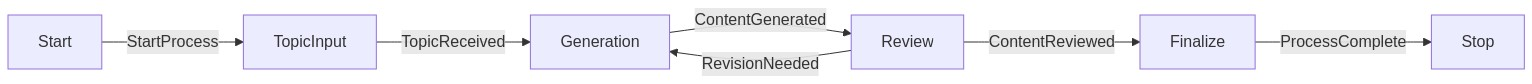

In [6]:
%%mermaidjs --img
flowchart LR
    A[Start] -->|StartProcess| B[TopicInput]
    B -->|TopicReceived| C[Generation]
    C -->|ContentGenerated| D[Review]
    D -->|RevisionNeeded| C
    D -->|ContentReviewed| E[Finalize]
    E -->|ProcessComplete| F[Stop]

In [14]:
# Define events for our content creation process
class ContentEvents(Enum):
    StartProcess = "startProcess"
    TopicReceived = "topicReceived"
    ContentGenerated = "contentGenerated"
    ContentReviewed = "contentReviewed"
    RevisionNeeded = "revisionNeeded"
    ProcessComplete = "processComplete"


# Define state for the content creation process
class ContentState(KernelBaseModel):
    topic: str = ""
    content: str = ""
    review: str = ""
    revision_count: int = 0
    max_revisions: int = 3

    def debug_info(self):
        return f"State: topic='{self.topic}', content_length={len(self.content)}, revision_count={self.revision_count}"


# Step to get the topic from the user
class TopicInputStep(KernelProcessStep[ContentState]):
    async def activate(self, state: KernelProcessStepState[ContentState]):
        """Activates the step and sets the state."""
        state.state = state.state or ContentState()
        self.state = state.state
        print(f"DEBUG - TopicInputStep activated: {self.state.debug_info()}")

    @kernel_function
    async def get_topic(self, context: KernelProcessStepContext):
        print("What topic would you like content about?")
        topic = input("TOPIC: ")

        self.state.topic = topic
        print(f"DEBUG - Setting topic to: '{self.state.topic}'")

        await context.emit_event(
            process_event=ContentEvents.TopicReceived, data=self.state
        )
        print(f"DEBUG - Emitted TopicReceived with state.topic = '{self.state.topic}'")


# Step to generate content
class ContentGenerationStep(KernelProcessStep[ContentState]):
    async def activate(self, state: KernelProcessStepState[ContentState]):
        """Activates the step and sets the state."""
        state.state = state.state or ContentState()
        self.state = state.state
        print(f"DEBUG - ContentGenerationStep activated: {self.state.debug_info()}")

    @kernel_function
    async def generate_content(
        self,
        context: KernelProcessStepContext,
        kernel: Kernel,
        content_state: ContentState = None,
    ):
        """Generates content based on the topic."""
        if content_state:
            print(
                f"DEBUG - Received content_state parameter with topic: '{content_state.topic}'"
            )
            self.state = content_state

        print(f"Generating content about: {self.state.topic}")

        # Get chat completion service and generate content
        chat_service = kernel.get_service(service_id="process-framework")
        settings = chat_service.instantiate_prompt_execution_settings(
            service_id="process-framework"
        )

        chat_history = ChatHistory()
        chat_history.add_system_message(
            f"You are a content creator specializing in {self.state.topic}."
        )
        chat_history.add_user_message(
            f"Write a short article about {self.state.topic}. Keep it concise but informative."
        )

        response = await chat_service.get_chat_message_contents(
            chat_history=chat_history, settings=settings
        )

        if response is None:
            raise ValueError(
                "Failed to get a response from the chat completion service."
            )

        self.state.content = response[0].content

        print("Content generated successfully!")
        print(f"DEBUG - Generated content length: {len(self.state.content)}")

        await context.emit_event(
            process_event=ContentEvents.ContentGenerated, data=self.state
        )
        print(f"DEBUG - Emitted ContentGenerated with state: {self.state.debug_info()}")


# Step to review the content
class ContentReviewStep(KernelProcessStep[ContentState]):
    async def activate(self, state: KernelProcessStepState[ContentState]):
        """Activates the step and sets the state."""
        state.state = state.state or ContentState()
        self.state = state.state
        print(f"DEBUG - ContentReviewStep activated: {self.state.debug_info()}")

    @kernel_function
    async def review_content(
        self,
        context: KernelProcessStepContext,
        kernel: Kernel,
        content_state: ContentState = None,
    ):
        """Reviews the generated content."""
        if content_state:
            print(
                f"DEBUG - Received content_state parameter with topic: '{content_state.topic}'"
            )
            self.state = content_state

        print("Reviewing the generated content...")

        # Get chat completion service and review content
        chat_service = kernel.get_service(service_id="process-framework")
        settings = chat_service.instantiate_prompt_execution_settings(
            service_id="process-framework"
        )

        chat_history = ChatHistory()
        chat_history.add_system_message(
            "You are a content reviewer. Your job is to review content and provide feedback."
        )
        chat_history.add_user_message(
            f"Review this content about {self.state.topic}:\n\n{self.state.content}\n\nProvide a brief review and state whether it needs revision or is good to publish."
        )

        response = await chat_service.get_chat_message_contents(
            chat_history=chat_history, settings=settings
        )

        if response is None:
            raise ValueError(
                "Failed to get a response from the chat completion service."
            )

        self.state.review = response[0].content

        print(f"Review: {self.state.review}")

        # Check if revision is needed
        needs_revision = (
            "revision" in self.state.review.lower()
            and self.state.revision_count < self.state.max_revisions
        )

        if needs_revision:
            self.state.revision_count += 1
            print(
                f"Revision needed. Revision count: {self.state.revision_count}/{self.state.max_revisions}"
            )
            await context.emit_event(
                process_event=ContentEvents.RevisionNeeded, data=self.state
            )
            print(
                f"DEBUG - Emitted RevisionNeeded with state: {self.state.debug_info()}"
            )
        else:
            print("Content approved or max revisions reached!")
            await context.emit_event(
                process_event=ContentEvents.ContentReviewed, data=self.state
            )
            print(
                f"DEBUG - Emitted ContentReviewed with state: {self.state.debug_info()}"
            )


# Step to finalize the process
class FinalizeStep(KernelProcessStep[ContentState]):
    async def activate(self, state: KernelProcessStepState[ContentState]):
        state.state = state.state or ContentState()
        self.state = state.state
        print(f"DEBUG - FinalizeStep activated: {self.state.debug_info()}")

    @kernel_function
    async def finalize(
        self, context: KernelProcessStepContext, content_state: ContentState = None
    ):
        """Finalizes the process and displays the results."""
        if content_state:
            print(
                f"DEBUG - Received content_state parameter with topic: '{content_state.topic}'"
            )
            self.state = content_state

        print("\n" + "=" * 50)
        print("CONTENT CREATION PROCESS COMPLETE")
        print("=" * 50)
        print(f"Topic: {self.state.topic}")
        print("-" * 50)
        print("Final Content:")
        print(self.state.content)
        print("-" * 50)
        print("Review:")
        print(self.state.review)
        print("-" * 50)
        print(f"Revisions: {self.state.revision_count}")
        print("=" * 50 + "\n")

        await context.emit_event(process_event=ContentEvents.ProcessComplete, data=None)

In [ ]:
# Function to run the content creation process
async def run_content_creation_process():
    # Create our kernel
    kernel = create_kernel_with_service(service_id="process-framework")
    print("Kernel created successfully!")

    # Create a process builder
    process = ProcessBuilder(name="ContentCreation")

    # Define the steps
    topic_step = process.add_step(TopicInputStep)
    generation_step = process.add_step(ContentGenerationStep)
    review_step = process.add_step(ContentReviewStep)
    finalize_step = process.add_step(FinalizeStep)

    # Define the input event that starts the process
    process.on_input_event(event_id=ContentEvents.StartProcess).send_event_to(
        target=topic_step
    )

    # Define the event flow with explicit parameter mapping
    topic_step.on_event(event_id=ContentEvents.TopicReceived).send_event_to(
        target=generation_step, parameter_name="content_state"
    )
    generation_step.on_event(event_id=ContentEvents.ContentGenerated).send_event_to(
        target=review_step, parameter_name="content_state"
    )
    review_step.on_event(event_id=ContentEvents.RevisionNeeded).send_event_to(
        target=generation_step, parameter_name="content_state"
    )
    review_step.on_event(event_id=ContentEvents.ContentReviewed).send_event_to(
        target=finalize_step, parameter_name="content_state"
    )
    finalize_step.on_event(event_id=ContentEvents.ProcessComplete).stop_process()

    # Build the kernel process
    kernel_process = process.build()

    # Start the process
    await start(
        process=kernel_process,
        kernel=kernel,
        initial_event=KernelProcessEvent(id=ContentEvents.StartProcess, data=None),
    )

In [ ]:
# Run the content creation process
# Uncomment the following line to run the content creation process
await run_content_creation_process()

## 4. Best Practices and Tips

When working with the Process Framework, keep these best practices in mind:

1. **Event-Driven Design**
   - Design your processes around events and state transitions
   - Use clear, descriptive event names (consider using Enum classes)
   - Plan for conditional branching and looping

2. **State Management**
   - Define clear state models using `KernelBaseModel`
   - Keep state changes as predictable and minimal as possible
   - Document the state structure and requirements

3. **Step Organization**
   - Break down complex processes into smaller, reusable steps
   - Use inheritance for steps with similar functionality
   - Keep each step focused on a single responsibility

4. **Error Handling**
   - Implement error handling in steps (try/except blocks)
   - Consider adding error events for graceful failure handling

5. **Testing**
   - Test each step independently
   - Create test cases for different state scenarios
   - Mock external services when testing

## 5. Advanced Patterns

The Process Framework supports several advanced patterns. Here are some examples:

### Conditional Branching
```python
# Example of conditional branching
review_step.on_event(event_id=ContentEvents.RevisionNeeded).send_event_to(target=generation_step)
review_step.on_event(event_id=ContentEvents.ContentReviewed).send_event_to(target=finalize_step)
```

### Stateful Steps
```python
# Example of a stateful step
class StatefulStep(KernelProcessStep[CustomState]):
    async def activate(self, state: KernelProcessStepState[CustomState]):
        self.state = state.state or CustomState()
        
    @kernel_function
    async def process_with_state(self, context: KernelProcessStepContext):
        # Access and modify state
        self.state.counter += 1
        
        if self.state.counter > 3:
            await context.emit_event(process_event=CustomEvents.LimitReached, data=None)
        else:
            await context.emit_event(process_event=CustomEvents.Continue, data=None)
```

### Process Composition
```python
# Example of process composition
def create_main_process():
    main_process = ProcessBuilder(name="MainProcess")
    
    # Add steps
    step1 = main_process.add_step(Step1)
    
    # Create and add a subprocess
    subprocess = create_subprocess()
    subprocess_step = main_process.add_step(subprocess)
    
    # Connect steps
    main_process.on_input_event(event_id=MainEvents.Start).send_event_to(target=step1)
    step1.on_event(event_id=Step1Events.Complete).send_event_to(target=subprocess_step)
    
    return main_process
```


## 6. Next Steps

Now that you understand the Process Framework, you can:

1. Create more complex workflows with branching and looping
2. Integrate with external services and APIs
3. Build reusable process components
4. Implement advanced error handling and recovery
5. Add monitoring and logging to your processes

For more detailed information and examples, check out the [Semantic Kernel documentation](https://learn.microsoft.com/en-us/semantic-kernel/frameworks/process/process-framework) and [GitHub samples](https://github.com/microsoft/semantic-kernel/tree/main/python/samples/getting_started_with_processes).